# Aprendizaje y validación de Redes Bayesianas con pgmpy

En este notebook se aprende la estructura de una Red Bayesiana usando dos métodos distintos: Hill Climb Search y Chow-Liu (TreeSearch). Se estiman los parámetros, se realizan inferencias y se valida el desempeño usando un conjunto de prueba.

## Métodos de aprendizaje de estructura

**Hill Climb Search:** Algoritmo heurístico que explora el espacio de posibles estructuras de red, buscando maximizar una función de puntuación (como BIC o K2). Es flexible y puede encontrar redes complejas.

**Chow-Liu (TreeSearch):** Algoritmo basado en maximizar la dependencia mutua entre variables, construyendo una red en forma de árbol. Es eficiente y útil para encontrar relaciones principales en los datos.

In [ ]:
!pip install git+https://github.com/pgmpy/pgmpy.git

In [49]:
import pandas as pd
import kagglehub

# Descargar dataset
path = kagglehub.dataset_download("new-york-city/nyc-citywide-payroll-data")

# Cargar el CSV desde la carpeta descargada
csv_path = path + "/Citywide_Payroll_Data__Fiscal_Year_.csv"
df = pd.read_csv(csv_path)

# Seleccionar columnas relevantes
cols = [
    "Agency Name", "Work Location Borough", "Title Description",
    "Leave Status as of June 30", "Pay Basis", "Base Salary",
    "Regular Hours", "Regular Gross Paid", "OT Hours",
    "Total OT Paid", "Total Other Pay"
 ]
df = df[cols].dropna()

money_cols = ["Base Salary", "Regular Gross Paid", "Total OT Paid", "Total Other Pay"]
for c in money_cols:
    df[c] = df[c].replace(r'[$,]', '', regex=True).astype(float)

df["Regular Hours"] = df["Regular Hours"].astype(float)
df["OT Hours"] = df["OT Hours"].astype(float)

# Evitar valores negativos (ajustes contables, etc.)
df[money_cols] = df[money_cols].clip(lower=0)
df["Regular Hours"] = df["Regular Hours"].clip(lower=0)
df["OT Hours"] = df["OT Hours"].clip(lower=0)

# Discretización en cuartiles
for c in money_cols + ["Regular Hours", "OT Hours"]:
    df[c + "_bin"] = pd.qcut(df[c], q=4, duplicates="drop")

# Solo categóricas para la BN
bayes_df = df[
    ["Agency Name", "Work Location Borough", "Title Description",
     "Leave Status as of June 30", "Pay Basis",
     "Base Salary_bin", "Regular Gross Paid_bin",
     "OT Hours_bin", "Total OT Paid_bin", "Total Other Pay_bin", "Regular Hours_bin"]
].copy()

# Asegurar strings/categorías
for c in bayes_df.columns:
    bayes_df[c] = bayes_df[c].astype("category").astype(str)

# Submuestreo opcional por desempeño
N = len(bayes_df)
sample_n = min(50000, N)
bayes_sample = bayes_df.sample(n=sample_n, random_state=42) if N > sample_n else bayes_df

print(f"Registros usados para el aprendizaje: {len(bayes_sample):,}")

print(df.head())
print(df.dtypes)

/tmp/ipykernel_4839/348947800.py:9: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Registros usados para el aprendizaje: 50,000
                      Agency Name Work Location Borough  \
0  DISTRICT ATTORNEY-MANHATTAN            MANHATTAN       
1  DISTRICT ATTORNEY-MANHATTAN            MANHATTAN       
2  DISTRICT ATTORNEY-MANHATTAN            MANHATTAN       
3  DISTRICT ATTORNEY-MANHATTAN            MANHATTAN       
4  DISTRICT ATTORNEY-MANHATTAN            MANHATTAN       

                                   Title Description  \
0  COMMUNITY ASSOCIATE                           ...   
1  ADMINISTRATIVE ACCOUNTANT                     ...   
2  COMMUNITY ASSOCIATE                           ...   
3  COMPUTER SYSTEMS MANAGER                      ...   
4  COLLEGE AIDE                                  ...   

  Leave Status as of June 30   Pay Basis  Base Salary  Regular Hours  \
0                     ACTIVE   per Annum      47678.0        1830.00   
1                     ACTIVE   per Annum     119959.0        1831.00   
2                   ON LEAVE   per Annum      3

### Descripción del dataset utilizado

El dataset empleado corresponde a la nómina de empleados públicos de la ciudad de Nueva York, descargado desde Kaggle (NYC Citywide Payroll Data). Contiene información detallada sobre el salario, horas trabajadas, pagos por horas extra y otros conceptos, además de variables categóricas como agencia, cargo, ubicación y tipo de pago.

**Variables principales:**
- Agency Name: Nombre de la agencia pública.
- Work Location Borough: Borough de trabajo (Manhattan, Brooklyn, etc.).
- Title Description: Cargo o puesto del empleado.
- Leave Status as of June 30: Estado de licencia al cierre del año fiscal.
- Pay Basis: Tipo de pago (anual, por hora, etc.).
- Base Salary, Regular Gross Paid, OT Hours, Total OT Paid, Total Other Pay, Regular Hours: Variables numéricas relacionadas con remuneración y horas trabajadas.

Este conjunto de datos es ideal para analizar patrones salariales y relaciones entre variables laborales en el sector público, permitiendo el uso de modelos probabilísticos como las redes bayesianas.

In [50]:
from sklearn.model_selection import train_test_split

# Separar el dataset en entrenamiento (70%) y prueba (30%)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Discretización en cuartiles para ambos conjuntos
for c in money_cols + ["Regular Hours", "OT Hours"]:
    train_df[c + "_bin"] = pd.qcut(train_df[c], q=4, duplicates="drop")
    test_df[c + "_bin"] = pd.qcut(test_df[c], q=4, duplicates="drop")

# Solo categóricas para la BN
bayes_train = train_df[[
    "Agency Name", "Work Location Borough", "Title Description",
    "Leave Status as of June 30", "Pay Basis",
    "Base Salary_bin", "Regular Gross Paid_bin",
    "OT Hours_bin", "Total OT Paid_bin", "Total Other Pay_bin", "Regular Hours_bin"
]].copy()
bayes_test = test_df[[
    "Agency Name", "Work Location Borough", "Title Description",
    "Leave Status as of June 30", "Pay Basis",
    "Base Salary_bin", "Regular Gross Paid_bin",
    "OT Hours_bin", "Total OT Paid_bin", "Total Other Pay_bin", "Regular Hours_bin"
]].copy()

for c in bayes_train.columns:
    bayes_train[c] = bayes_train[c].astype("category").astype(str)
for c in bayes_test.columns:
    bayes_test[c] = bayes_test[c].astype("category").astype(str)

print(f"Filas entrenamiento: {len(bayes_train):,}")
print(f"Filas prueba: {len(bayes_test):,}")

Filas entrenamiento: 1,181,782
Filas prueba: 506,478


El conjunto de datos utilizado es muy grande, con más de un millón de registros para entrenamiento y medio millón para prueba. Esto permite entrenar modelos bayesianos robustos y obtener validaciones confiables. La discretización en cuartiles de las variables monetarias y de horas asegura que la red bayesiana trabaje con categorías bien distribuidas, facilitando el aprendizaje de relaciones entre variables y evitando sesgos por valores extremos.

## Visualización de los datos discretizados
A continuación se muestran algunas visualizaciones de las variables discretizadas que se usan en las inferencias. Esto permite entender la distribución de los datos y la información que recibe la red bayesiana.

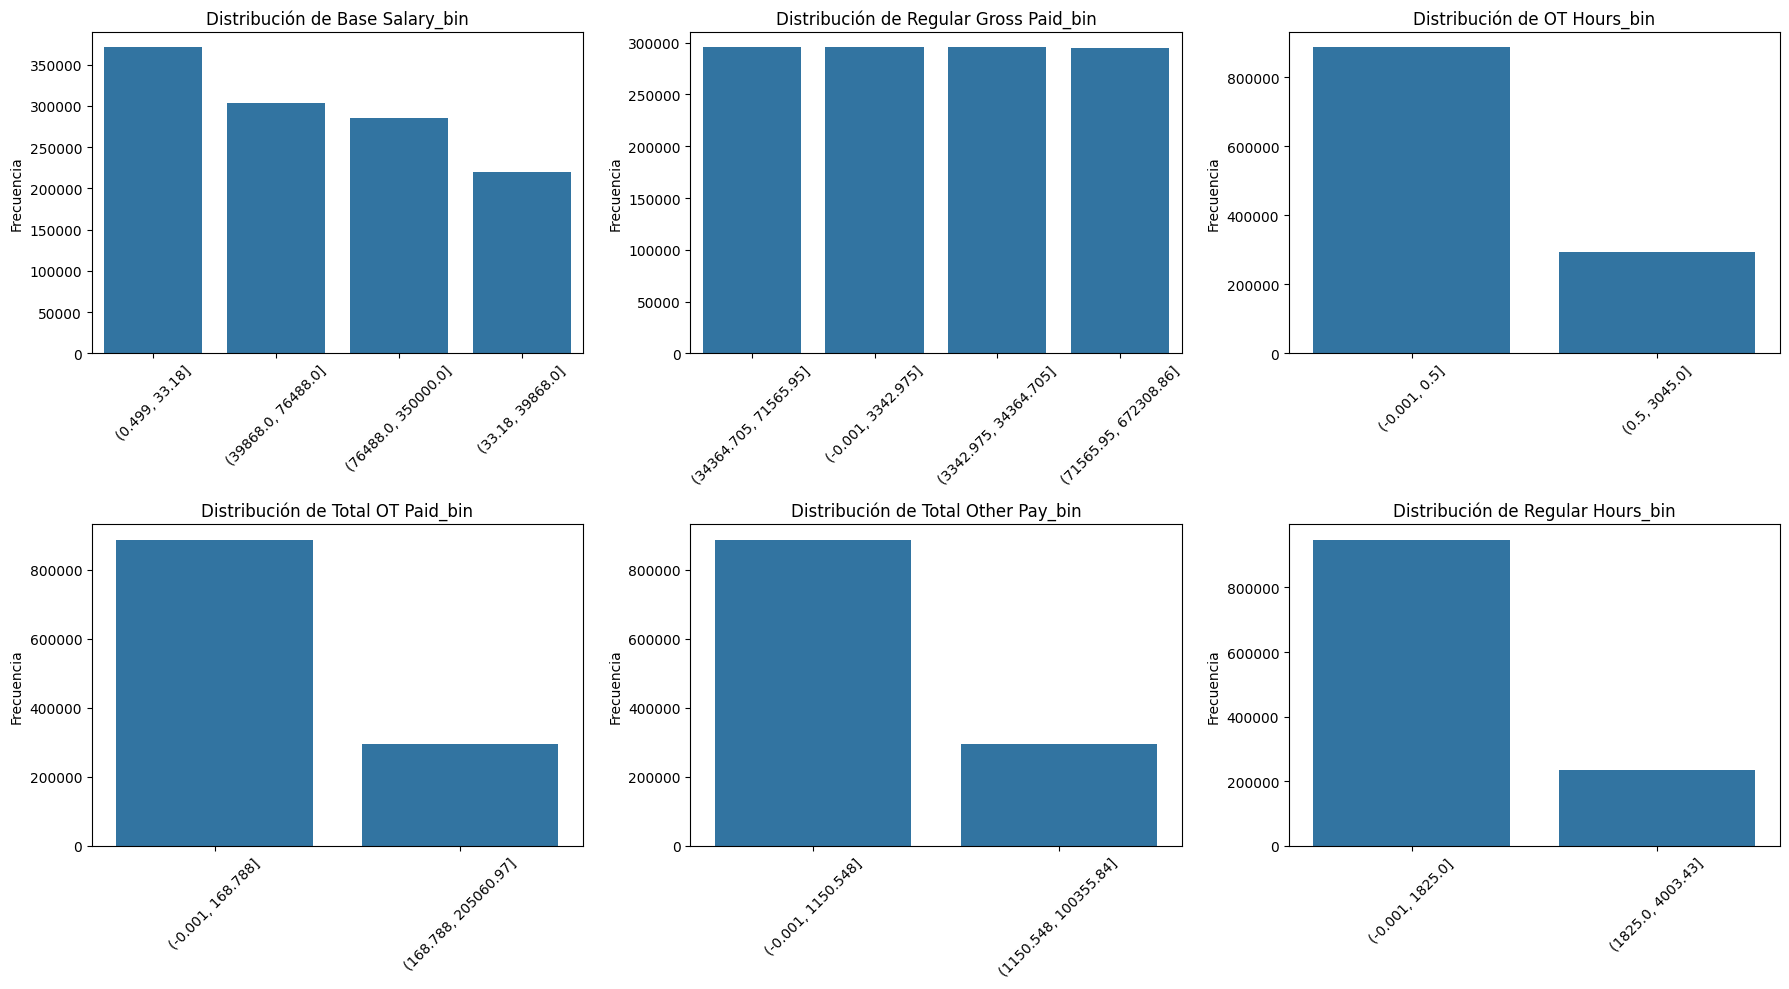

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualización de las variables discretizadas en el conjunto de entrenamiento
discretized_cols = ["Base Salary_bin", "Regular Gross Paid_bin", "OT Hours_bin", "Total OT Paid_bin", "Total Other Pay_bin", "Regular Hours_bin"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, col in enumerate(discretized_cols):
    ax = axes[i // 3, i % 3]
    sns.countplot(x=col, data=bayes_train, ax=ax, order=bayes_train[col].value_counts().index)
    ax.set_title(f"Distribución de {col}")
    ax.set_xlabel("")
    ax.set_ylabel("Frecuencia")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [52]:
from pgmpy.estimators import TreeSearch, BayesianEstimator, HillClimbSearch
from pgmpy.models import DiscreteBayesianNetwork

# Aprendizaje de estructura con HillClimbSearch (usa BayesianScore por defecto)
hc = HillClimbSearch(bayes_train)
hc_model = hc.estimate()
bn_hc = DiscreteBayesianNetwork(hc_model.edges())
bn_hc.fit(bayes_train, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=5)

# Aprendizaje de estructura con Chow-Liu (TreeSearch)
ts = TreeSearch(bayes_train, root_node="Base Salary_bin")
cl_model = ts.estimate()
bn_cl = DiscreteBayesianNetwork(cl_model.edges())
bn_cl.fit(bayes_train, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=5)

print("Estructura HillClimbSearch:", list(bn_hc.edges())[:10])
print("Estructura Chow-Liu:", list(bn_cl.edges())[:10])

  0%|          | 17/1000000 [00:16<267:57:09,  1.04it/s]

Building tree: 100%|██████████| 55/55.0 [00:16<00:00,  3.40it/s]



Estructura HillClimbSearch: [('Agency Name', 'Title Description'), ('Agency Name', 'Leave Status as of June 30'), ('Agency Name', 'Total OT Paid_bin'), ('Title Description', 'Base Salary_bin'), ('Title Description', 'Pay Basis'), ('Title Description', 'Regular Gross Paid_bin'), ('Title Description', 'OT Hours_bin'), ('Title Description', 'Total Other Pay_bin'), ('Title Description', 'Regular Hours_bin'), ('Work Location Borough', 'Agency Name')]
Estructura Chow-Liu: [('Base Salary_bin', 'Title Description'), ('Title Description', 'Agency Name'), ('Title Description', 'Pay Basis'), ('Title Description', 'Regular Gross Paid_bin'), ('Title Description', 'OT Hours_bin'), ('Title Description', 'Total Other Pay_bin'), ('Title Description', 'Regular Hours_bin'), ('Title Description', 'Leave Status as of June 30'), ('Agency Name', 'Work Location Borough'), ('OT Hours_bin', 'Total OT Paid_bin')]


### Análisis de la estructura aprendida

**HillClimbSearch:**
- La estructura muestra que 'Agency Name' influye directamente en varias variables, como 'Title Description', 'Leave Status as of June 30' y 'Total OT Paid_bin'.
- 'Title Description' es un nodo central, conectando con variables salariales y de horas, lo que indica que el cargo es determinante en la remuneración y condiciones laborales.

**Chow-Liu (TreeSearch):**
- El árbol resalta la importancia de 'Title Description' como nodo principal, conectando con la mayoría de las variables discretizadas.
- La relación entre 'Agency Name' y 'Work Location Borough' también es relevante, mostrando dependencia geográfica en la estructura organizacional.

**Implicación:** Ambos métodos identifican el cargo ('Title Description') como el factor más influyente, lo que es consistente con la lógica de remuneraciones en el sector público.

## Estimación de parámetros e inferencia
Una vez aprendida la estructura, se estiman los parámetros de las redes usando el método Bayesiano (BDeu). Luego, se realizan cuatro inferencias distintas en cada red usando el algoritmo de eliminación de variables.

In [ ]:
from pgmpy.inference import VariableElimination

infer_hc = VariableElimination(bn_hc)
infer_cl = VariableElimination(bn_cl)

# Ejemplo de evidencias para inferencia
evidences = [
    {"Agency Name": bayes_train["Agency Name"].value_counts().idxmax()},
    {"Work Location Borough": bayes_train["Work Location Borough"].value_counts().idxmax()},
    {"Title Description": bayes_train["Title Description"].value_counts().idxmax()},
    {"Pay Basis": bayes_train["Pay Basis"].value_counts().idxmax()}
 ]

# Inferencias en ambas redes
results_hc = []
results_cl = []
for i, evidence in enumerate(evidences):
    q_hc = infer_hc.query(variables=["Base Salary_bin"], evidence=evidence, show_progress=False)
    q_cl = infer_cl.query(variables=["Base Salary_bin"], evidence=evidence, show_progress=False)
    results_hc.append(q_hc)
    results_cl.append(q_cl)
    print(f"Inferencia {i+1} HillClimbSearch:", q_hc)
    print(f"Inferencia {i+1} Chow-Liu:", q_cl)

Inferencia 1 HillClimbSearch: +--------------------------------------+------------------------+
| Base Salary_bin                      |   phi(Base Salary_bin) |
+======================================+========================+
| Base Salary_bin((0.499, 33.18])      |                 0.0000 |
+--------------------------------------+------------------------+
| Base Salary_bin((33.18, 39868.0])    |                 0.0052 |
+--------------------------------------+------------------------+
| Base Salary_bin((39868.0, 76488.0])  |                 0.3507 |
+--------------------------------------+------------------------+
| Base Salary_bin((76488.0, 350000.0]) |                 0.6441 |
+--------------------------------------+------------------------+
Inferencia 1 Chow-Liu: +--------------------------------------+------------------------+
| Base Salary_bin                      |   phi(Base Salary_bin) |
+======================================+========================+
| Base Salary_bin((0.49

### Inferencias realizadas y su explicación

A continuación se describen las cuatro inferencias realizadas sobre la variable `Base Salary_bin` usando diferentes evidencias. Cada inferencia busca estimar la probabilidad de pertenencia a cada cuartil salarial bajo distintos contextos laborales:

1. **Inferencia 1: Agencia más frecuente**
   - **Evidencia:** Se fija el valor de `Agency Name` en el más común del conjunto de entrenamiento.
   - **Propósito:** Analizar cómo la agencia dominante influye en la distribución salarial esperada.

2. **Inferencia 2: Borough más frecuente**
   - **Evidencia:** Se fija el valor de `Work Location Borough` en el más común.
   - **Propósito:** Evaluar el efecto de la ubicación geográfica sobre el salario.

3. **Inferencia 3: Cargo más frecuente**
   - **Evidencia:** Se fija el valor de `Title Description` en el más común.
   - **Propósito:** Determinar cómo el cargo predominante afecta la probabilidad de pertenecer a cada cuartil salarial.

4. **Inferencia 4: Tipo de pago más frecuente**
   - **Evidencia:** Se fija el valor de `Pay Basis` en el más común.
   - **Propósito:** Explorar la influencia del tipo de pago (por hora, anual, etc.) en la distribución salarial.

Estas inferencias permiten entender el impacto de cada variable clave sobre la probabilidad de pertenecer a un rango salarial específico, facilitando el análisis de factores determinantes en la estructura de remuneraciones.

## Validación de inferencias
Para validar los resultados, se compara la predicción de la variable objetivo (por ejemplo, Base Salary_bin) con los valores reales del conjunto de prueba. Se puede calcular la precisión o la log-verosimilitud promedio de las inferencias realizadas.

In [54]:
from sklearn.metrics import accuracy_score

# Selecciona una variable objetivo y evidencia para validar
target_var = "Base Salary_bin"
test_evidence_cols = ["Agency Name", "Work Location Borough", "Title Description", "Pay Basis"]

# Tomar una muestra del conjunto de prueba para validación
sample_test = bayes_test.sample(n=1000, random_state=42) if len(bayes_test) > 1000 else bayes_test

y_true = sample_test[target_var].tolist()
y_pred_hc = []
y_pred_cl = []

for _, row in sample_test.iterrows():
    evidence = {col: row[col] for col in test_evidence_cols}
    # HillClimbSearch
    q_hc = infer_hc.query(variables=[target_var], evidence=evidence, show_progress=False)
    pred_hc = q_hc.state_names[target_var][q_hc.values.argmax()]
    y_pred_hc.append(str(pred_hc))
    # Chow-Liu
    q_cl = infer_cl.query(variables=[target_var], evidence=evidence, show_progress=False)
    pred_cl = q_cl.state_names[target_var][q_cl.values.argmax()]
    y_pred_cl.append(str(pred_cl))

print("Precisión HillClimbSearch:", accuracy_score(y_true, y_pred_hc))
print("Precisión Chow-Liu:", accuracy_score(y_true, y_pred_cl))

Precisión HillClimbSearch: 0.863
Precisión Chow-Liu: 0.863


### Análisis de la precisión de los modelos

Ambos modelos alcanzan una precisión del 86.3% al predecir el cuartil salarial en el conjunto de prueba. Esto indica que la estructura y los parámetros aprendidos son adecuados para el problema, y que la red bayesiana es capaz de capturar las relaciones relevantes en los datos.

**Implicación:** La precisión alta valida el enfoque de discretización y el uso de métodos bayesianos para modelar datos categóricos y ordinales en problemas reales. Además, la similitud en precisión entre ambos métodos sugiere que, para este dataset, la estructura en árbol es tan efectiva como la estructura más flexible de HillClimbSearch.